In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.linear_model import Lasso, LinearRegression, ElasticNet
from sklearn.ensemble import RandomForestRegressor
import statsmodels.api as sm
from statsmodels.regression.rolling import RollingOLS
import arch

lss = [(0, (1, 10)), '--', '-.', (0, (1, 1)), (0, (3, 5, 1, 5, 1, 5)), (0, (3, 1, 1, 1, 1, 1))]
flag_ls = True

In [2]:
SMALL_SIZE = 14
MEDIUM_SIZE = 15
BIGGER_SIZE = 15

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [3]:
def sharpe(x):
    return x.mean() / x.std() * np.sqrt(12)

def sortino_ratio(x):
    mean = x.mean()
    std_neg = x[x<0].std()
    return mean / std_neg * np.sqrt(12)

def bootstrap_dataset(data, id_vars, value_var, func, n=500):
    enclosure_flag = (type(id_vars) != list) or (len(id_vars) == 1)
    if type(id_vars) != list:
        id_vars = [id_vars]
    bs_dfs = []
    for conf, group_df in data.groupby(id_vars):
        values = group_df[value_var].values
        values_size = values.size
        boot = [func(values[np.random.randint(values_size, size=values_size)]) for it in range(n)]
        if enclosure_flag: 
            conf = [conf]
        data_dict = dict(zip(id_vars, conf))
        data_dict[value_var] = boot
        
        bs_dfs.append(pd.DataFrame(data_dict))
    return pd.concat(bs_dfs)

def summary_table(expected_returns, sharpe, sortino, index_names, group_col, alpha=0.05, n_digits=2):
    alpha_2 = alpha / 2
    funcs = [
        'mean',
        lambda x: np.quantile(x, alpha_2), 
        lambda x: np.quantile(x, 1-alpha_2),
    ]
    func_names = ['mean', 'ci_low', 'ci_up']
    
    df_returns = expected_returns[expected_returns['trading_strategy'] == 'both']
    df_sharpe = sharpe[sharpe['trading_strategy'] == 'both']
    df_sortino = sortino[sortino['trading_strategy'] == 'both']
    
    agg_returns_df = df_returns.groupby(group_col)['value'].agg(funcs)
    agg_returns_df = (agg_returns_df * 100).round(n_digits).astype(str) + '\%'
    agg_returns_df.columns = func_names
    p_neg_returns = df_returns.groupby(group_col)['value'].apply(lambda x: (x < 0).mean()).round(n_digits)
    agg_sharpe_df = df_sharpe.groupby(group_col)['value'].agg(funcs).round(n_digits).astype(str)
    agg_sharpe_df.columns = func_names
    agg_sortino_df = df_sortino.groupby(group_col)['value'].agg(funcs).round(n_digits).astype(str)
    agg_sortino_df.columns = func_names
    
    summary = pd.DataFrame({
        'Excess Returns': agg_returns_df['mean'],
        'Sharpe Ratio': agg_sharpe_df['mean'],
        'Sortino Ratio': agg_sortino_df['mean'],
        # r'$\mathbb{P}(\mathbb{E}[R] < 0)$': p_neg_returns,
        '\ ': '\\\\ ',
        '\  ': ' (' + agg_returns_df['ci_low'] + '-' + agg_returns_df['ci_up'] + ')',
        '\   ': ' (' + agg_sharpe_df['ci_low'] + '-' + agg_sharpe_df['ci_up'] + ')',
        '\    ': ' (' + agg_sortino_df['ci_low'] + '-' + agg_sortino_df['ci_up'] + ')',
        # '\     ': '&'
    })
    summary.index.names = index_names
    # summary = summary.reset_index()
    
    print(summary.to_latex(bold_rows=True,
                       caption='This is the caption',
                       escape=False,
                       # column_format='lllllrlll'
                      ))
    
    return summary

# SP500

In [4]:
results_df = pd.read_pickle('data/results_sp500.pkl')
results_df['trading_strategy'] = results_df['trading_method'].str.split(' ', expand=True).iloc[:, -1].values
results_df = results_df[results_df['avg_month_returns'] != 0].drop(columns=['index',])

clean_results_df = results_df.drop(columns=['n_positions_avg', 'n_positions_compl', 'n_positions_pair'])
melted_results_df = clean_results_df.melt(clean_results_df.columns[3:])
melted_results_df = melted_results_df[melted_results_df['value'] != 0]

melted_results_df_no_bench = melted_results_df[melted_results_df['benchmark'] == False].copy()
spreads_method_config = melted_results_df_no_bench['spreads_method'].str.split(' ', expand=True).iloc[:, 1:]
melted_results_df_no_bench['spreads_method_config'] = spreads_method_config[1] + ' ' + spreads_method_config[2]
melted_results_df_no_bench[['trading_method_name', 'w', 'q', 'gamma', 'trading_strategy']] = melted_results_df_no_bench['trading_method'].str.split(' ', expand=True)
melted_results_df_no_bench = melted_results_df_no_bench[melted_results_df_no_bench['q'] != 'q=0.5'].reset_index(drop=True)
melted_results_df_no_bench['gamma-q'] = melted_results_df_no_bench['gamma'] + ' - ' + melted_results_df_no_bench['q']
melted_results_df_no_bench['w'] = melted_results_df_no_bench['w'].str.split('=', expand=True)[1].astype(int)
melted_results_df_no_bench['corr-k'] = melted_results_df_no_bench['spreads_method'].str.split('-', expand=True)[1]
melted_results_df_no_bench['value'] = 2 ** melted_results_df_no_bench['value'] - 1

benchmark_returns = 2 ** results_df[results_df['benchmark']]['avg_month_returns'] - 1
expected_return_benchmark = benchmark_returns.mean()
expected_sharpe_benchmark = sharpe(benchmark_returns)
expected_sortino_benchmark = sortino_ratio(benchmark_returns)

sp500_index_returns = pd.read_csv('data/sp500_returns.csv', parse_dates=['Date'])
sp500_return_benchmark = sp500_index_returns['Returns'].mean()
sp500_sharpe_benchmark = sharpe(sp500_index_returns['Returns'])
sp500_sortino_benchmark = sortino_ratio(sp500_index_returns['Returns'])

In [5]:
bs_expected_returns_residuals_method = bootstrap_dataset(
    melted_results_df_no_bench[melted_results_df_no_bench['variable'] == 'avg_month_returns'], 
    id_vars=['trading_strategy', 'residuals_method'], 
    value_var='value', func=np.mean, n=5000)

bs_expected_sharpe_residuals_method = bootstrap_dataset(
    melted_results_df_no_bench[melted_results_df_no_bench['variable'] == 'avg_month_returns'], 
    id_vars=['trading_strategy', 'residuals_method'], 
    value_var='value', func=sharpe, n=5000)

bs_expected_sortino_residuals_method = bootstrap_dataset(
    melted_results_df_no_bench[melted_results_df_no_bench['variable'] == 'avg_month_returns'], 
    id_vars=['trading_strategy', 'residuals_method'], 
    value_var='value', func=sortino_ratio, n=5000)

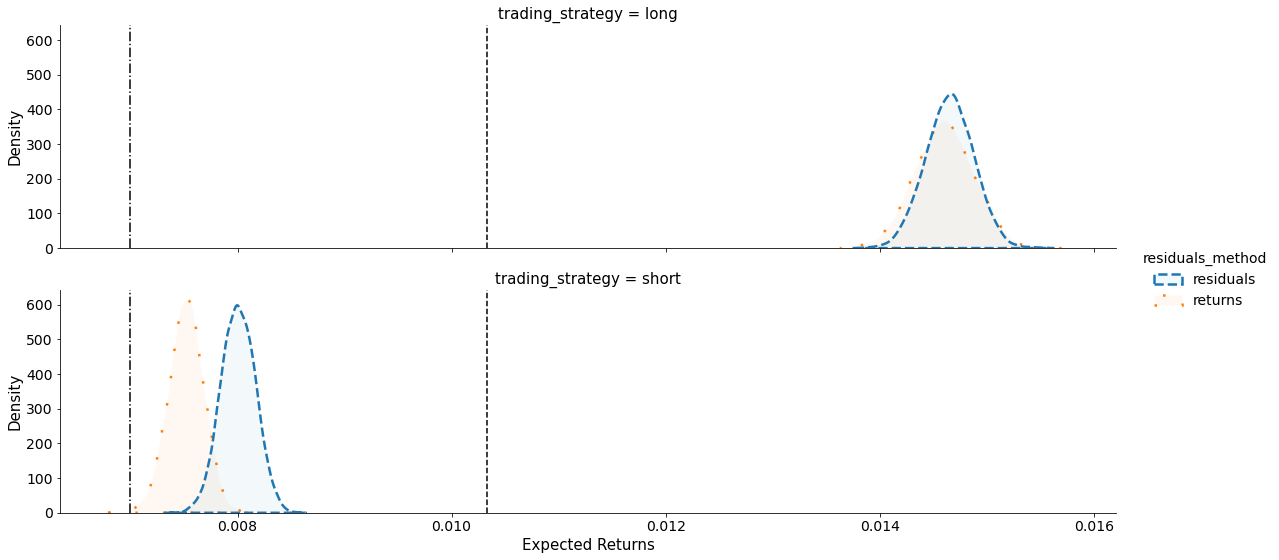

In [6]:
g = sns.displot(data=bs_expected_returns_residuals_method[bs_expected_returns_residuals_method['trading_strategy'] != 'both'], 
                x='value', kind='kde', fill=True, alpha=.05, linewidth=2.5,
                hue='residuals_method', row='trading_strategy', aspect=4, height=4)
    
if flag_ls:
    for ax in g.axes.flat:
        for line, ls in zip(ax.collections, lss):
            line.set_linestyle(ls)
        ax.axvline(expected_return_benchmark, ls='--', color='black')
        ax.axvline(sp500_return_benchmark, ls='-.', color='black')

    handles = g._legend.legendHandles[::-1]
    for handle, ls in zip(handles, lss):
        handle.set_ls(ls)
else:
    for ax in g.axes.flat:
        ax.axvline(expected_return_benchmark, ls='--', color='black')
        ax.axvline(sp500_return_benchmark, ls='-.', color='black')
        
plt.xlabel('Expected Returns')

plt.savefig('img/SP500_long_short_returns_preprocessing.pdf')
plt.show()

In [7]:
summary = summary_table(bs_expected_returns_residuals_method, 
                        bs_expected_sharpe_residuals_method, 
                        bs_expected_sortino_residuals_method, 
                        group_col='residuals_method', index_names=['Method'])
summary.style.highlight_max(summary.columns[:3])

\begin{table}
\centering
\caption{This is the caption}
\begin{tabular}{llllllll}
\toprule
{} & Excess Returns & Sharpe Ratio & Sortino Ratio &   \  &               \   &          \    &         \     \\
\textbf{Method   } &                &              &               &      &                   &               &               \\
\midrule
\textbf{residuals} &         0.82\% &         0.47 &          0.76 &  \\  &   (0.78\%-0.86\%) &   (0.45-0.49) &    (0.71-0.8) \\
\textbf{returns  } &         0.86\% &         0.36 &          0.58 &  \\  &    (0.8\%-0.91\%) &   (0.34-0.39) &   (0.54-0.62) \\
\bottomrule
\end{tabular}
\end{table}



,Excess Returns,Sharpe Ratio,Sortino Ratio,\,\,\,\
Method,,,,,,,
residuals,0.82\%,0.47,0.76,\\,(0.78\%-0.86\%),(0.45-0.49),(0.71-0.8)
returns,0.86\%,0.36,0.58,\\,(0.8\%-0.91\%),(0.34-0.39),(0.54-0.62)


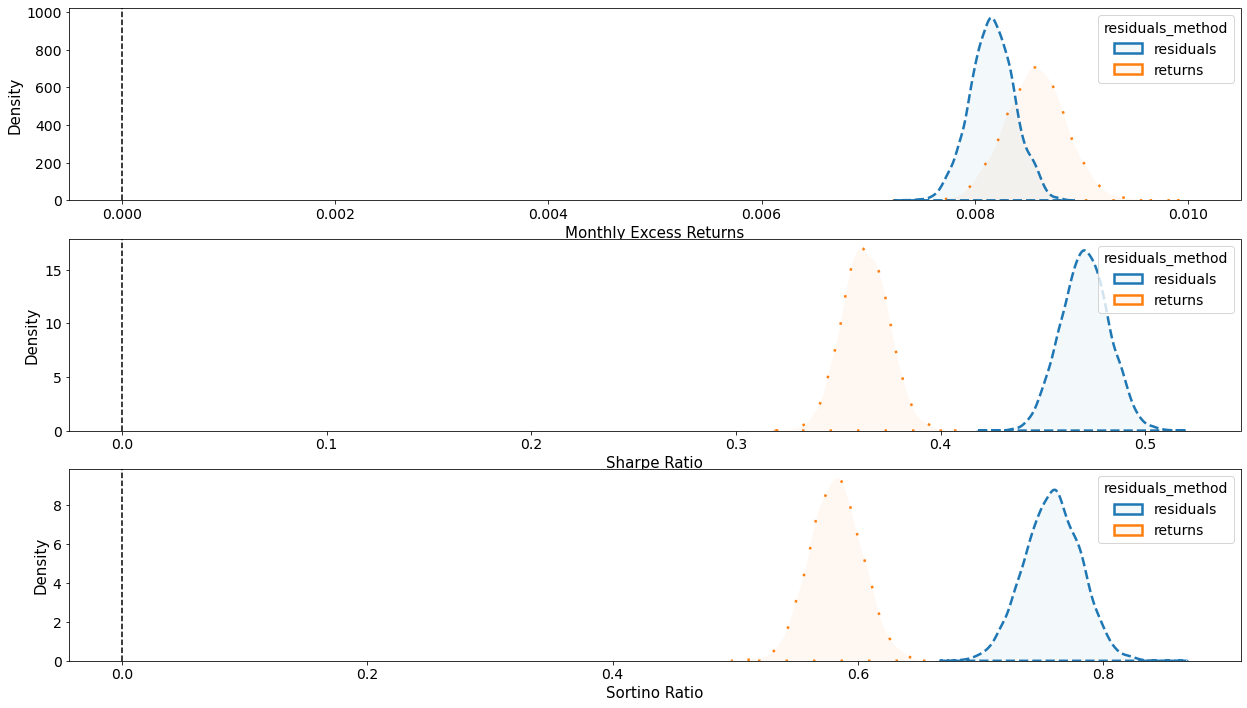

In [8]:
fig, axs = plt.subplots(3, figsize=(21, 12))

sns.kdeplot(data=bs_expected_returns_residuals_method[bs_expected_returns_residuals_method['trading_strategy'] == 'both'], 
            x='value', fill=True, alpha=.05,
            hue='residuals_method', linewidth=2.5, ax=axs[0])
axs[0].set_xlabel('Monthly Excess Returns')

sns.kdeplot(data=bs_expected_sharpe_residuals_method[bs_expected_sharpe_residuals_method['trading_strategy'] == 'both'], 
            x='value', fill=True, alpha=.05,
            hue='residuals_method', linewidth=2.5, ax=axs[1])
axs[1].set_xlabel('Sharpe Ratio')

sns.kdeplot(data=bs_expected_sortino_residuals_method[bs_expected_sortino_residuals_method['trading_strategy'] == 'both'], 
            x='value', fill=True, alpha=.05,
            hue='residuals_method', linewidth=2.5, ax=axs[2], )
axs[2].set_xlabel('Sortino Ratio')

if flag_ls:
    for ax in axs:
        for line, ls in zip(ax.collections, lss):
            line.set_linestyle(ls)
        ax.axvline(0, ls='--', color='black')

    handles = g._legend.legendHandles[::-1]
    for handle, ls in zip(handles, lss):
        handle.set_ls(ls)
else:
    for ax in axs:
        ax.axvline(0, ls='--', color='black')
        
plt.savefig('img/SP500_preprocessing.pdf')
plt.show()

In [9]:
bs_expected_returns_corr = bootstrap_dataset(
    melted_results_df_no_bench[((~melted_results_df_no_bench['corr-k'].isna()) &
                                (melted_results_df_no_bench['variable'] == 'avg_month_returns')
                               )], 
    id_vars=['trading_strategy', 'corr-k', 'spreads_method_name'], 
    value_var='value', func=np.mean, n=5000)
bs_expected_returns_corr['corr-k'] = bs_expected_returns_corr['corr-k'].astype(int)


bs_expected_sharpe_corr = bootstrap_dataset(
    melted_results_df_no_bench[((~melted_results_df_no_bench['corr-k'].isna()) &
                                (melted_results_df_no_bench['variable'] == 'avg_month_returns')
                               )], 
    id_vars=['trading_strategy', 'corr-k', 'spreads_method_name'], 
    value_var='value', func=sharpe, n=5000)
bs_expected_sharpe_corr['corr-k'] = bs_expected_returns_corr['corr-k'].astype(int)


bs_expected_sortino_corr = bootstrap_dataset(
    melted_results_df_no_bench[((~melted_results_df_no_bench['corr-k'].isna()) &
                                (melted_results_df_no_bench['variable'] == 'avg_month_returns')
                               )], 
    id_vars=['trading_strategy', 'corr-k', 'spreads_method_name'], 
    value_var='value', func=sortino_ratio, n=5000)
bs_expected_sortino_corr['corr-k'] = bs_expected_sortino_corr['corr-k'].astype(int)

In [10]:
summary = summary_table(bs_expected_returns_corr, 
                        bs_expected_sharpe_corr, 
                        bs_expected_sortino_corr, 
                        group_col='spreads_method_name', index_names=['Method'])

\begin{table}
\centering
\caption{This is the caption}
\begin{tabular}{llllllll}
\toprule
{} & Excess Returns & Sharpe Ratio & Sortino Ratio &   \  &               \   &          \    &         \     \\
\textbf{Method } &                &              &               &      &                   &               &               \\
\midrule
\textbf{Corr-1 } &         0.57\% &         0.44 &          0.65 &  \\  &   (0.49\%-0.65\%) &    (0.38-0.5) &   (0.54-0.75) \\
\textbf{Corr-20} &         0.77\% &         0.44 &          0.74 &  \\  &   (0.67\%-0.87\%) &    (0.39-0.5) &   (0.63-0.86) \\
\textbf{Corr-5 } &         0.69\% &         0.44 &          0.72 &  \\  &    (0.6\%-0.78\%) &    (0.39-0.5) &   (0.61-0.84) \\
\textbf{Corr-50} &         0.88\% &         0.47 &          0.79 &  \\  &   (0.77\%-0.99\%) &   (0.42-0.53) &   (0.68-0.91) \\
\bottomrule
\end{tabular}
\end{table}



In [11]:
print(summary.loc[['Corr-1', 'Corr-5', 'Corr-20', 'Corr-50']].to_latex(bold_rows=True,
                       caption='This is the caption',
                       escape=False,
                      ))
summary.style.highlight_max(summary.columns[:3])

\begin{table}
\centering
\caption{This is the caption}
\begin{tabular}{llllllll}
\toprule
{} & Excess Returns & Sharpe Ratio & Sortino Ratio &   \  &               \   &          \    &         \     \\
\textbf{Method } &                &              &               &      &                   &               &               \\
\midrule
\textbf{Corr-1 } &         0.57\% &         0.44 &          0.65 &  \\  &   (0.49\%-0.65\%) &    (0.38-0.5) &   (0.54-0.75) \\
\textbf{Corr-5 } &         0.69\% &         0.44 &          0.72 &  \\  &    (0.6\%-0.78\%) &    (0.39-0.5) &   (0.61-0.84) \\
\textbf{Corr-20} &         0.77\% &         0.44 &          0.74 &  \\  &   (0.67\%-0.87\%) &    (0.39-0.5) &   (0.63-0.86) \\
\textbf{Corr-50} &         0.88\% &         0.47 &          0.79 &  \\  &   (0.77\%-0.99\%) &   (0.42-0.53) &   (0.68-0.91) \\
\bottomrule
\end{tabular}
\end{table}



,Excess Returns,Sharpe Ratio,Sortino Ratio,\,\,\,\
Method,,,,,,,
Corr-1,0.57\%,0.44,0.65,\\,(0.49\%-0.65\%),(0.38-0.5),(0.54-0.75)
Corr-20,0.77\%,0.44,0.74,\\,(0.67\%-0.87\%),(0.39-0.5),(0.63-0.86)
Corr-5,0.69\%,0.44,0.72,\\,(0.6\%-0.78\%),(0.39-0.5),(0.61-0.84)
Corr-50,0.88\%,0.47,0.79,\\,(0.77\%-0.99\%),(0.42-0.53),(0.68-0.91)


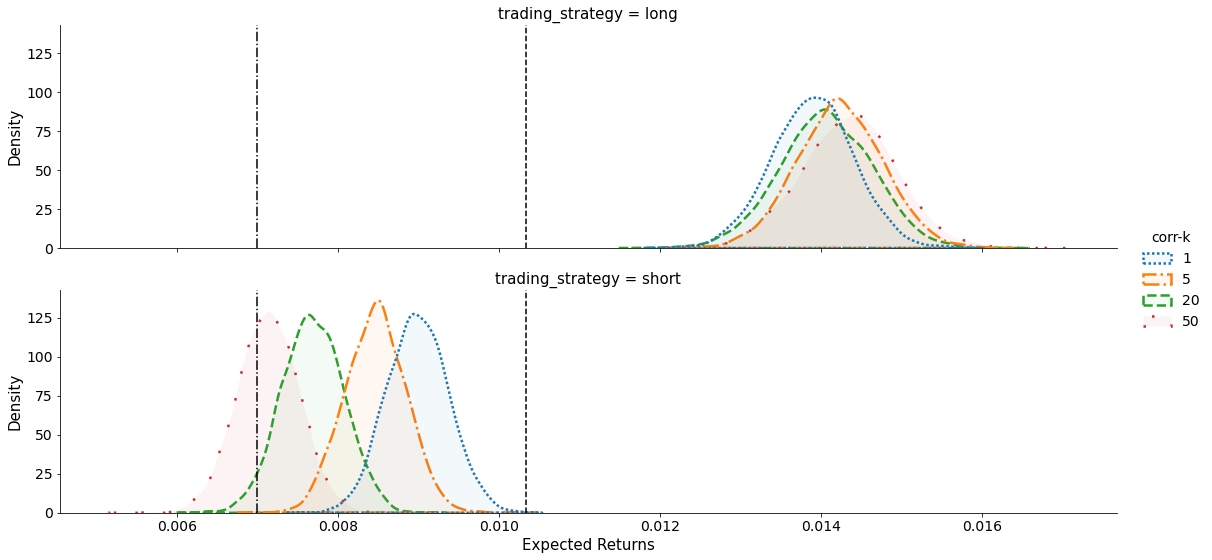

In [12]:
g = sns.displot(data=bs_expected_returns_corr[bs_expected_returns_corr['trading_strategy'] != 'both'], 
                x='value', kind='kde', fill=True, alpha=.05, aspect=4, height=4,
            hue='corr-k', row='trading_strategy', linewidth=2.5, palette='tab10')
    
if flag_ls:
    for ax in g.axes.flat:
        for line, ls in zip(ax.collections, lss):
            line.set_linestyle(ls)
        ax.axvline(expected_return_benchmark, ls='--', color='black')
        ax.axvline(sp500_return_benchmark, ls='-.', color='black')

    handles = g._legend.legendHandles[::-1]
    for handle, ls in zip(handles, lss):
        handle.set_ls(ls)
else:
    for ax in g.axes.flat:
        ax.axvline(expected_return_benchmark, ls='--', color='black')
        ax.axvline(sp500_return_benchmark, ls='-.', color='black')
    
plt.xlabel('Expected Returns')
    
plt.savefig('img/SP500_long_short_returns_corr_k.pdf')
plt.show()

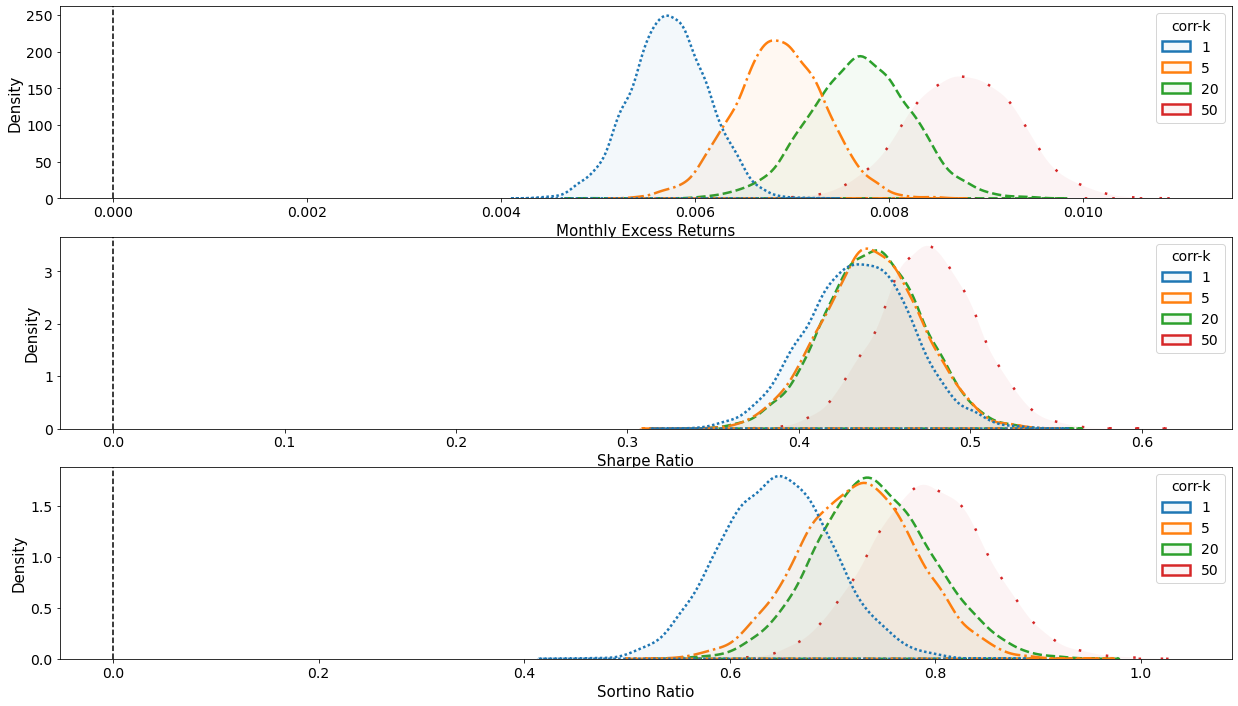

In [13]:
fig, axs = plt.subplots(3, figsize=(21, 12))

sns.kdeplot(data=bs_expected_returns_corr[bs_expected_returns_corr['trading_strategy'] == 'both'], 
            x='value', fill=True, alpha=.05, palette='tab10',
            hue='corr-k', linewidth=2.5, ax=axs[0])
axs[0].set_xlabel('Monthly Excess Returns')

sns.kdeplot(data=bs_expected_sharpe_corr[bs_expected_sharpe_corr['trading_strategy'] == 'both'], 
            x='value', fill=True, alpha=.05, palette='tab10',
            hue='corr-k', linewidth=2.5, ax=axs[1])
axs[1].set_xlabel('Sharpe Ratio')

sns.kdeplot(data=bs_expected_sortino_corr[bs_expected_sortino_corr['trading_strategy'] == 'both'], 
            x='value', fill=True, alpha=.05, palette='tab10',
            hue='corr-k', linewidth=2.5, ax=axs[2])
axs[2].set_xlabel('Sortino Ratio')

if flag_ls:
    for ax in axs:
        for line, ls in zip(ax.collections, lss):
            line.set_linestyle(ls)
        ax.axvline(0, ls='--', color='black')

    handles = g._legend.legendHandles[::-1]
    for handle, ls in zip(handles, lss):
        handle.set_ls(ls)
else:
    for ax in axs:
        ax.axvline(0, ls='--', color='black')
        
plt.savefig('img/SP500_corr_K_spreads.pdf')
plt.show()

In [14]:
bs_expected_returns_graph = bootstrap_dataset(
    melted_results_df_no_bench[((melted_results_df_no_bench['spreads_method_name'].isin(['SGS', 'LGMRF'])) &
                                (melted_results_df_no_bench['variable'] == 'avg_month_returns')
                               )], 
    id_vars=['trading_strategy', 'spreads_method_config', 'spreads_method_name'], 
    value_var='value', func=np.mean, n=5000)

bs_expected_sharpe_graph = bootstrap_dataset(
    melted_results_df_no_bench[((melted_results_df_no_bench['spreads_method_name'].isin(['SGS', 'LGMRF'])) &
                                (melted_results_df_no_bench['variable'] == 'avg_month_returns')
                               )], 
    id_vars=['trading_strategy', 'spreads_method_config', 'spreads_method_name'], 
    value_var='value', func=sharpe, n=5000)

bs_expected_sortino_graph = bootstrap_dataset(
    melted_results_df_no_bench[((melted_results_df_no_bench['spreads_method_name'].isin(['SGS', 'LGMRF'])) &
                                (melted_results_df_no_bench['variable'] == 'avg_month_returns')
                               )], 
    id_vars=['trading_strategy', 'spreads_method_config', 'spreads_method_name'], 
    value_var='value', func=sortino_ratio, n=5000)

In [15]:
bs_expected_returns_graph['spread_method'] = bs_expected_returns_graph['spreads_method_name'] + ' ' + bs_expected_returns_graph['spreads_method_config']
bs_expected_sharpe_graph['spread_method'] = bs_expected_sharpe_graph['spreads_method_name'] + ' ' + bs_expected_sharpe_graph['spreads_method_config']
bs_expected_sortino_graph['spread_method'] = bs_expected_sortino_graph['spreads_method_name'] + ' ' + bs_expected_sortino_graph['spreads_method_config']

In [16]:
g.axes

array([[<AxesSubplot:title={'center':'trading_strategy = long'}, ylabel='Density'>],
       [<AxesSubplot:title={'center':'trading_strategy = short'}, xlabel='Expected Returns', ylabel='Density'>]],
      dtype=object)

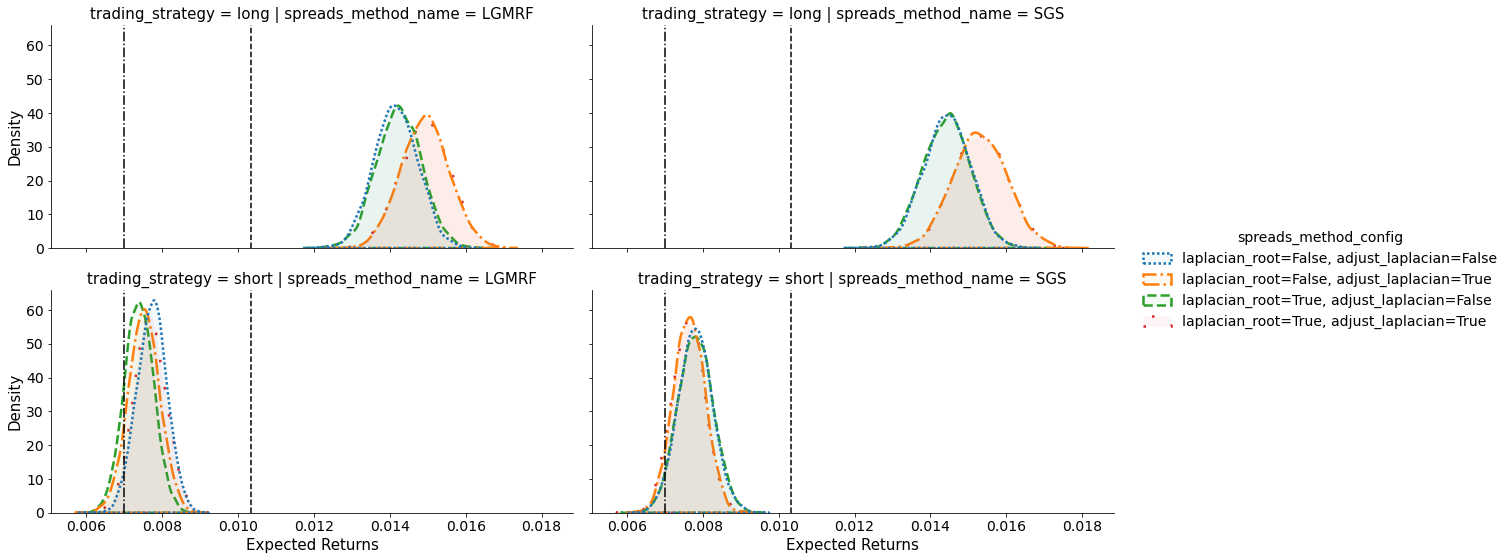

In [17]:
g = sns.displot(data=bs_expected_returns_graph[bs_expected_returns_graph['trading_strategy'] != 'both'], 
                x='value', kind='kde', fill=True, alpha=.05, aspect=2, height=4,
            hue='spreads_method_config', row='trading_strategy', col='spreads_method_name', linewidth=2.5)
    
if flag_ls:
    for ax in g.axes.flat:
        for line, ls in zip(ax.collections, lss):
            line.set_linestyle(ls)
        ax.axvline(expected_return_benchmark, ls='--', color='black')
        ax.axvline(sp500_return_benchmark, ls='-.', color='black')

    handles = g._legend.legendHandles[::-1]
    for handle, ls in zip(handles, lss):
        handle.set_ls(ls)
else:
    for ax in g.axes.flat:
        ax.axvline(expected_return_benchmark, ls='--', color='black')
        ax.axvline(sp500_return_benchmark, ls='-.', color='black')

g.axes[1, 0].set_xlabel('Expected Returns')
g.axes[1, 1].set_xlabel('Expected Returns')

plt.savefig('img/SP500_long_short_returns_graph.pdf')
plt.show()

In [18]:
summary = summary_table(bs_expected_returns_graph, 
                        bs_expected_sharpe_graph, 
                        bs_expected_sortino_graph, 
                        group_col='spread_method', index_names=['Method'])
summary.index = summary.index.str.replace('adjust_laplacian=False', 'no-adjust')
summary.index = summary.index.str.replace('adjust_laplacian=True', 'adjust')
summary.index = summary.index.str.replace('laplacian_root=False', 'no-root')
summary.index = summary.index.str.replace('laplacian_root=True', 'root')
print(summary.to_latex(bold_rows=True,
                       caption='This is the caption',
                       escape=False,
                      ))
summary.style.highlight_max(summary.columns[:4])

\begin{table}
\centering
\caption{This is the caption}
\begin{tabular}{llllllll}
\toprule
{} & Excess Returns & Sharpe Ratio & Sortino Ratio &   \  &               \   &          \    &         \     \\
\textbf{Method                                            } &                &              &               &      &                   &               &               \\
\midrule
\textbf{LGMRF laplacian_root=False, adjust_laplacian=False} &         0.79\% &         0.43 &           0.7 &  \\  &   (0.68\%-0.89\%) &   (0.38-0.49) &   (0.59-0.81) \\
\textbf{LGMRF laplacian_root=False, adjust_laplacian=True } &         0.89\% &         0.42 &          0.68 &  \\  &   (0.77\%-1.02\%) &   (0.37-0.48) &   (0.58-0.79) \\
\textbf{LGMRF laplacian_root=True, adjust_laplacian=False } &         0.84\% &         0.45 &          0.73 &  \\  &   (0.73\%-0.95\%) &    (0.39-0.5) &   (0.62-0.84) \\
\textbf{LGMRF laplacian_root=True, adjust_laplacian=True  } &         0.87\% &          0.4 &          0.62 

,Excess Returns,Sharpe Ratio,Sortino Ratio,\,\,\,\
Method,,,,,,,
"LGMRF no-root, no-adjust",0.79\%,0.43,0.7,\\,(0.68\%-0.89\%),(0.38-0.49),(0.59-0.81)
"LGMRF no-root, adjust",0.89\%,0.42,0.68,\\,(0.77\%-1.02\%),(0.37-0.48),(0.58-0.79)
"LGMRF root, no-adjust",0.84\%,0.45,0.73,\\,(0.73\%-0.95\%),(0.39-0.5),(0.62-0.84)
"LGMRF root, adjust",0.87\%,0.4,0.62,\\,(0.74\%-1.0\%),(0.34-0.45),(0.52-0.73)
"SGS no-root, no-adjust",0.89\%,0.4,0.61,\\,(0.76\%-1.01\%),(0.34-0.46),(0.51-0.72)
"SGS no-root, adjust",0.91\%,0.38,0.61,\\,(0.78\%-1.05\%),(0.32-0.44),(0.5-0.71)
"SGS root, no-adjust",0.89\%,0.4,0.61,\\,(0.76\%-1.02\%),(0.34-0.46),(0.51-0.71)
"SGS root, adjust",0.92\%,0.38,0.61,\\,(0.77\%-1.06\%),(0.33-0.44),(0.51-0.71)


In [19]:
aux_returns_graph_df = bs_expected_returns_graph[bs_expected_returns_graph['trading_strategy'] == 'both'].copy()
aux_returns_graph_df['Metric'] = 'Monthly Excess Return'
aux_sharpe_graph_df = bs_expected_sharpe_graph[bs_expected_sharpe_graph['trading_strategy'] == 'both'].copy()
aux_sharpe_graph_df['Metric'] = 'Sharpe Ratio'
aux_sortino_graph_df = bs_expected_sortino_graph[bs_expected_sortino_graph['trading_strategy'] == 'both'].copy()
aux_sortino_graph_df['Metric'] = 'Sortino Ratio'
aux_graph_df = pd.concat([aux_returns_graph_df, aux_sharpe_graph_df, aux_sortino_graph_df])
aux_graph_df

,trading_strategy,spreads_method_config,spreads_method_name,value,spread_method,Metric
0,both,"laplacian_root=False, adjust_laplacian=False",LGMRF,0.007320,"LGMRF laplacian_root=False, adjust_laplacian=F...",Monthly Excess Return
1,both,"laplacian_root=False, adjust_laplacian=False",LGMRF,0.007747,"LGMRF laplacian_root=False, adjust_laplacian=F...",Monthly Excess Return
2,both,"laplacian_root=False, adjust_laplacian=False",LGMRF,0.007617,"LGMRF laplacian_root=False, adjust_laplacian=F...",Monthly Excess Return
3,both,"laplacian_root=False, adjust_laplacian=False",LGMRF,0.008131,"LGMRF laplacian_root=False, adjust_laplacian=F...",Monthly Excess Return
4,both,"laplacian_root=False, adjust_laplacian=False",LGMRF,0.006885,"LGMRF laplacian_root=False, adjust_laplacian=F...",Monthly Excess Return
...,...,...,...,...,...,...
4995,both,"laplacian_root=True, adjust_laplacian=True",SGS,0.529933,"SGS laplacian_root=True, adjust_laplacian=True",Sortino Ratio
4996,both,"laplacian_root=True, adjust_laplacian=True",SGS,0.594417,"SGS laplacian_root=True, adjust_laplacian=True",Sortino Ratio
4997,both,"laplacian_root=True, adjust_laplacian=True",SGS,0.542874,"SGS laplacian_root=True, adjust_laplacian=True",Sortino Ratio
4998,both,"laplacian_root=True, adjust_laplacian=True",SGS,0.629688,"SGS laplacian_root=True, adjust_laplacian=True",Sortino Ratio


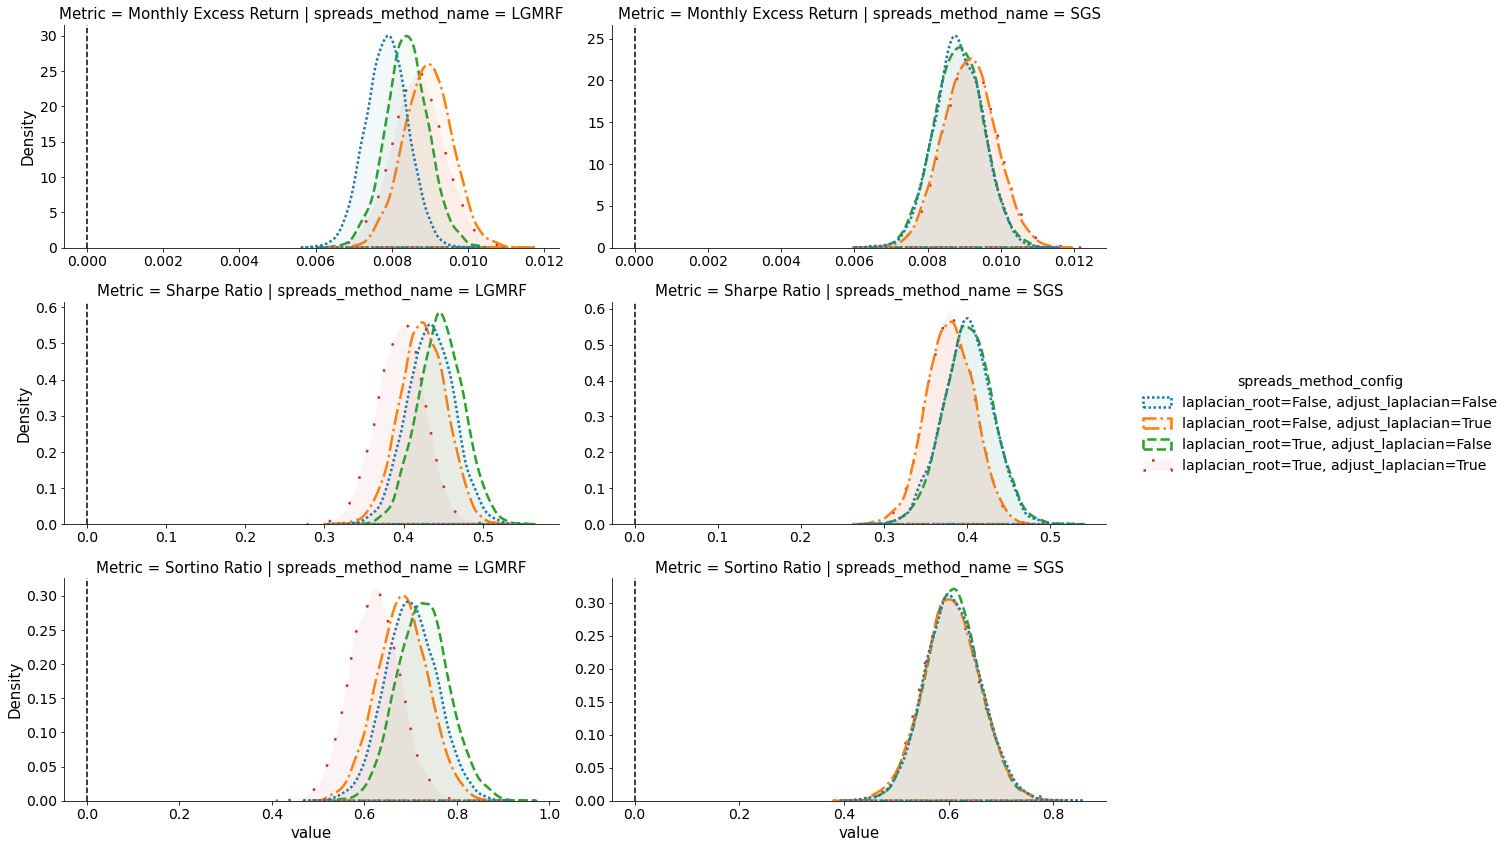

In [20]:
g = sns.displot(data=aux_graph_df, row='Metric', col='spreads_method_name',
                x='value', kind='kde', fill=True, alpha=.05, aspect=2, height=4,
            hue='spreads_method_config', linewidth=2.5, facet_kws=dict(sharex=False, sharey=False))
    
if flag_ls:
    for ax in g.axes.flat:
        for line, ls in zip(ax.collections, lss):
            line.set_linestyle(ls)
        ax.axvline(0, ls='--', color='black')

    handles = g._legend.legendHandles[::-1]
    for handle, ls in zip(handles, lss):
        handle.set_ls(ls)
else:
    for ax in g.axes.flat:
        ax.axvline(0, ls='--', color='black')

plt.savefig('img/SP500_graph_spreads.pdf')
plt.show()

In [21]:
corr_50_filt = (melted_results_df_no_bench['corr-k'].isna() | (melted_results_df_no_bench['corr-k'] == '50'))
adjust_laplacian_false_filt = ((~melted_results_df_no_bench['spreads_method_name'].isin(['SGS', 'LGMRF'])) | 
                               melted_results_df_no_bench['spreads_method'].str.endswith('laplacian_root=True, adjust_laplacian=False'))
spread_configs = melted_results_df_no_bench['spreads_method'].unique()[[0, 4, 5, 10]]
spread_config_filt = melted_results_df_no_bench['spreads_method'].isin(spread_configs)

bs_expected_returns_spread_method = bootstrap_dataset(
    melted_results_df_no_bench[(spread_config_filt &
                                (melted_results_df_no_bench['variable'] == 'avg_month_returns')
                               )], 
    id_vars=['trading_strategy', 'spreads_method_name'], 
    value_var='value', func=np.mean, n=5000)

bs_expected_sharpe_spread_method = bootstrap_dataset(
    melted_results_df_no_bench[(spread_config_filt &
                                (melted_results_df_no_bench['variable'] == 'avg_month_returns')
                               )], 
    id_vars=['trading_strategy', 'spreads_method_name'], 
    value_var='value', func=sharpe, n=5000)

bs_expected_sortino_spread_method = bootstrap_dataset(
    melted_results_df_no_bench[(spread_config_filt &
                                (melted_results_df_no_bench['variable'] == 'avg_month_returns')
                               )], 
    id_vars=['trading_strategy', 'spreads_method_name'], 
    value_var='value', func=sortino_ratio, n=5000)

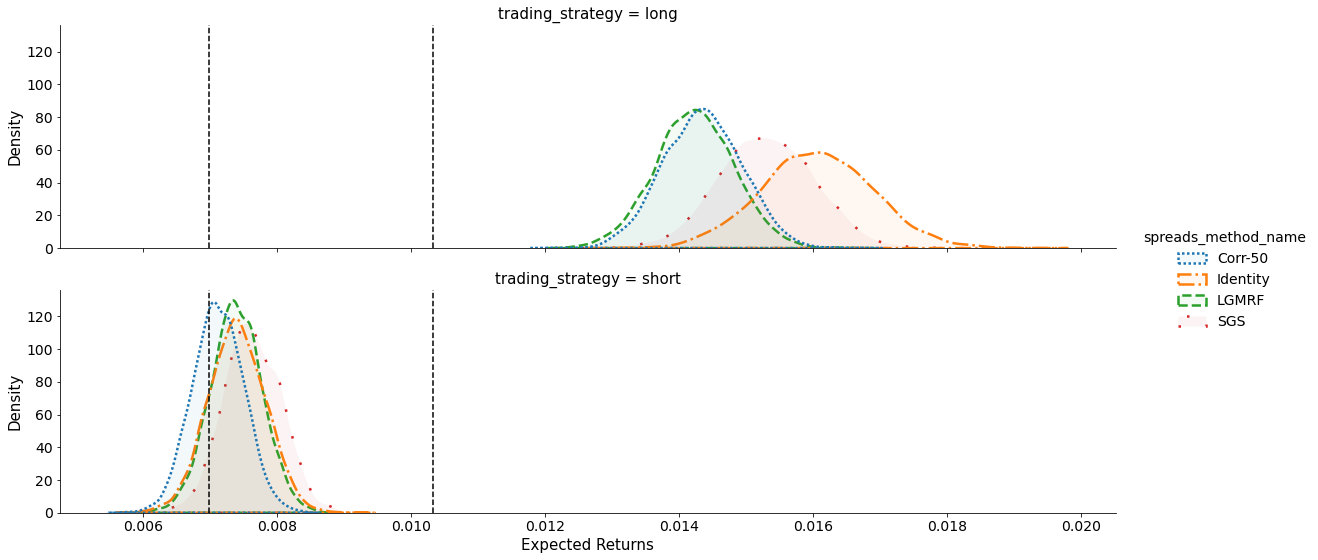

In [22]:
g = sns.displot(data=bs_expected_returns_spread_method[bs_expected_returns_spread_method['trading_strategy'] != 'both'], 
                x='value', kind='kde', fill=True, alpha=.05,
                hue='spreads_method_name', row='trading_strategy', 
                aspect=4, height=4, linewidth=2.5)
    
if flag_ls:
    for ax in g.axes.flat:
        for line, ls in zip(ax.collections, lss):
            line.set_linestyle(ls)
        ax.axvline(expected_return_benchmark, ls='--', color='black')
        ax.axvline(sp500_return_benchmark, ls='--', color='black')

    handles = g._legend.legendHandles[::-1]
    for handle, ls in zip(handles, lss):
        handle.set_ls(ls)
else:
    for ax in g.axes.flat:
        ax.axvline(expected_return_benchmark, ls='--', color='black')
        ax.axvline(sp500_return_benchmark, ls='--', color='black')


plt.xlabel('Expected Returns')
        
plt.savefig('img/SP500_long_short_returns_spread.pdf')
plt.show()

In [23]:
summary = summary_table(bs_expected_returns_spread_method, 
                        bs_expected_sharpe_spread_method, 
                        bs_expected_sortino_spread_method, 
                        group_col='spreads_method_name', index_names=['Method'])

summary.style.highlight_max(summary.columns[:3])

\begin{table}
\centering
\caption{This is the caption}
\begin{tabular}{llllllll}
\toprule
{} & Excess Returns & Sharpe Ratio & Sortino Ratio &   \  &               \   &          \    &         \     \\
\textbf{Method  } &                &              &               &      &                   &               &               \\
\midrule
\textbf{Corr-50 } &         0.88\% &         0.47 &          0.79 &  \\  &   (0.77\%-0.98\%) &   (0.42-0.53) &   (0.69-0.91) \\
\textbf{Identity} &         0.99\% &         0.35 &          0.65 &  \\  &   (0.82\%-1.16\%) &     (0.3-0.4) &   (0.53-0.78) \\
\textbf{LGMRF   } &         0.84\% &         0.45 &          0.73 &  \\  &   (0.72\%-0.95\%) &    (0.39-0.5) &   (0.62-0.84) \\
\textbf{SGS     } &         0.92\% &         0.38 &           0.6 &  \\  &   (0.77\%-1.06\%) &   (0.33-0.43) &    (0.5-0.71) \\
\bottomrule
\end{tabular}
\end{table}



,Excess Returns,Sharpe Ratio,Sortino Ratio,\,\,\,\
Method,,,,,,,
Corr-50,0.88\%,0.47,0.79,\\,(0.77\%-0.98\%),(0.42-0.53),(0.69-0.91)
Identity,0.99\%,0.35,0.65,\\,(0.82\%-1.16\%),(0.3-0.4),(0.53-0.78)
LGMRF,0.84\%,0.45,0.73,\\,(0.72\%-0.95\%),(0.39-0.5),(0.62-0.84)
SGS,0.92\%,0.38,0.6,\\,(0.77\%-1.06\%),(0.33-0.43),(0.5-0.71)


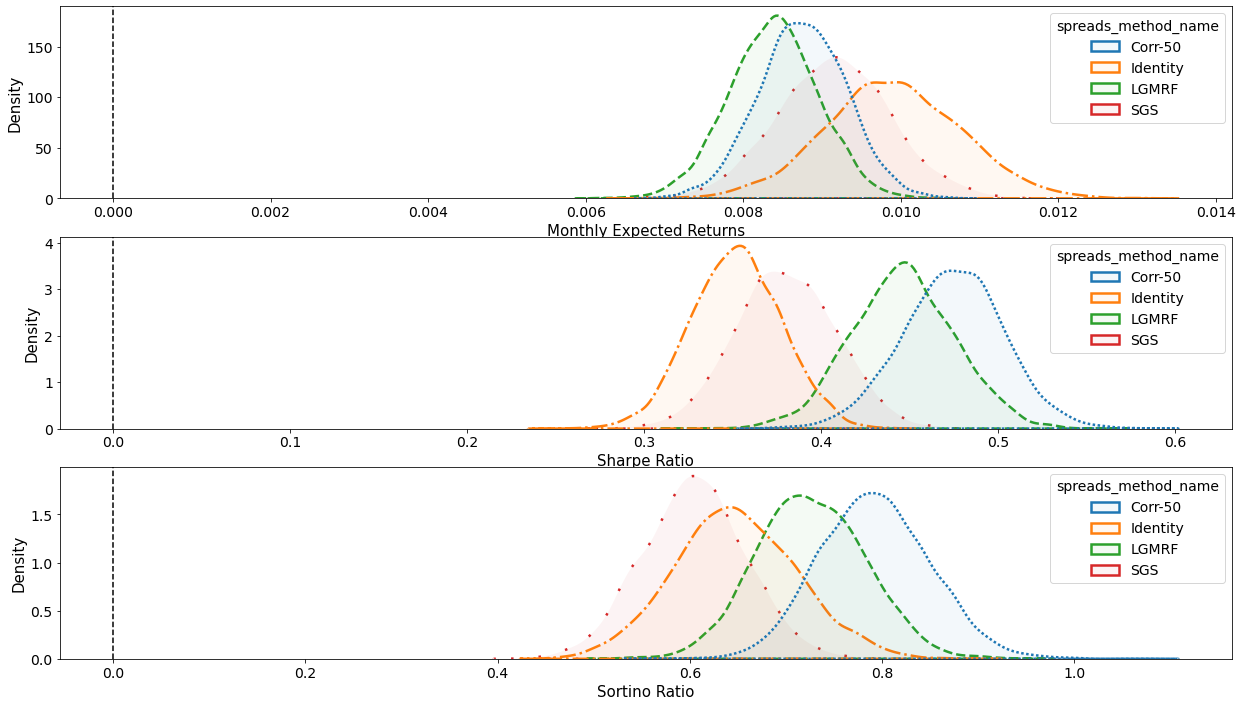

In [24]:
fig, axs = plt.subplots(3, figsize=(21, 12))

sns.kdeplot(data=bs_expected_returns_spread_method[bs_expected_returns_spread_method['trading_strategy'] == 'both'], 
            x='value', fill=True, alpha=.05, palette='tab10',
            hue='spreads_method_name', linewidth=2.5, ax=axs[0])
axs[0].set_xlabel('Monthly Expected Returns')

sns.kdeplot(data=bs_expected_sharpe_spread_method[bs_expected_sharpe_spread_method['trading_strategy'] == 'both'], 
            x='value', fill=True, alpha=.05, palette='tab10',
            hue='spreads_method_name', linewidth=2.5, ax=axs[1])
axs[1].set_xlabel('Sharpe Ratio')

sns.kdeplot(data=bs_expected_sortino_spread_method[bs_expected_sortino_spread_method['trading_strategy'] == 'both'], 
            x='value', fill=True, alpha=.05, palette='tab10',
            hue='spreads_method_name', linewidth=2.5, ax=axs[2])
axs[2].set_xlabel('Sortino Ratio')

if flag_ls:
    for ax in axs:
        for line, ls in zip(ax.collections, lss):
            line.set_linestyle(ls)
        ax.axvline(0, ls='--', color='black')
else:
    for ax in axs:
        ax.axvline(0, ls='--', color='black')
        
plt.savefig('img/SP500_spreads.pdf')
plt.show()

In [25]:
bs_expected_returns_trading_methods = bootstrap_dataset(
    melted_results_df_no_bench[melted_results_df_no_bench['variable'] == 'avg_month_returns'], 
    id_vars=['trading_strategy', 'w', 'gamma-q'], 
    value_var='value', func=np.mean, n=5000)

bs_expected_sharpe_trading_methods = bootstrap_dataset(
    melted_results_df_no_bench[melted_results_df_no_bench['variable'] == 'avg_month_returns'], 
    id_vars=['trading_strategy', 'w', 'gamma-q'], 
    value_var='value', func=sharpe, n=5000)

bs_expected_sortino_trading_methods = bootstrap_dataset(
    melted_results_df_no_bench[melted_results_df_no_bench['variable'] == 'avg_month_returns'], 
    id_vars=['trading_strategy', 'w', 'gamma-q'], 
    value_var='value', func=sortino_ratio, n=5000)

In [26]:
aux_returns_trading_df = bs_expected_returns_trading_methods[bs_expected_returns_trading_methods['trading_strategy'] == 'both'].copy()
aux_returns_trading_df['Metric'] = 'Monthly Excess Return'
aux_sharpe_trading_df = bs_expected_sharpe_trading_methods[bs_expected_sharpe_trading_methods['trading_strategy'] == 'both'].copy()
aux_sharpe_trading_df['Metric'] = 'Sharpe Ratio'
aux_sortino_trading_df = bs_expected_sortino_trading_methods[bs_expected_sortino_trading_methods['trading_strategy'] == 'both'].copy()
aux_sortino_trading_df['Metric'] = 'Sortino Ratio'
aux_trading_df = pd.concat([aux_returns_trading_df, aux_sharpe_trading_df, aux_sortino_trading_df]).rename(columns={'gamma-q': 'Config'})
aux_trading_df

,trading_strategy,w,Config,value,Metric
0,both,1,gamma=2 - q=0.1,0.012241,Monthly Excess Return
1,both,1,gamma=2 - q=0.1,0.011897,Monthly Excess Return
2,both,1,gamma=2 - q=0.1,0.011687,Monthly Excess Return
3,both,1,gamma=2 - q=0.1,0.012721,Monthly Excess Return
4,both,1,gamma=2 - q=0.1,0.012328,Monthly Excess Return
...,...,...,...,...,...
4995,both,24,gamma=None - q=0.2,0.655700,Sortino Ratio
4996,both,24,gamma=None - q=0.2,0.528436,Sortino Ratio
4997,both,24,gamma=None - q=0.2,0.358588,Sortino Ratio
4998,both,24,gamma=None - q=0.2,0.475393,Sortino Ratio


In [27]:
# aux_returns_trading_df['gamma'] = aux_returns_trading_df['gamma-q'].str.split(expand=True)[0].str.split('=', expand=True)[1]
# aux_returns_trading_df['q'] = aux_returns_trading_df['gamma-q'].str.split(expand=True)[2].str.split('=', expand=True)[1]
# aux_sharpe_trading_df['gamma'] = aux_sharpe_trading_df['gamma-q'].str.split(expand=True)[0].str.split('=', expand=True)[1]
# aux_sharpe_trading_df['q'] = aux_sharpe_trading_df['gamma-q'].str.split(expand=True)[2].str.split('=', expand=True)[1]
# aux_sortino_trading_df['gamma'] = aux_sortino_trading_df['gamma-q'].str.split(expand=True)[0].str.split('=', expand=True)[1]
# aux_sortino_trading_df['q'] = aux_sortino_trading_df['gamma-q'].str.split(expand=True)[2].str.split('=', expand=True)[1]

aux_returns_trading_df['Config'] = 'w=' + aux_returns_trading_df['w'].astype(str) + ' - ' + aux_returns_trading_df['gamma-q']
aux_sharpe_trading_df['Config'] = 'w=' + aux_sharpe_trading_df['w'].astype(str) + ' - ' + aux_sharpe_trading_df['gamma-q']
aux_sortino_trading_df['Config'] = 'w=' + aux_sortino_trading_df['w'].astype(str) + ' - ' + aux_sortino_trading_df['gamma-q']

summary = summary_table(aux_returns_trading_df, 
                        aux_sharpe_trading_df, 
                        aux_sortino_trading_df, 
                        group_col='Config', index_names=['Configuration'])

\begin{table}
\centering
\caption{This is the caption}
\begin{tabular}{llllllll}
\toprule
{} & Excess Returns & Sharpe Ratio & Sortino Ratio &   \  &               \   &          \    &         \     \\
\textbf{Configuration            } &                &              &               &      &                   &               &               \\
\midrule
\textbf{w=1 - gamma=2 - q=0.1    } &         1.23\% &         0.59 &          0.99 &  \\  &   (1.06\%-1.41\%) &    (0.5-0.68) &   (0.82-1.15) \\
\textbf{w=1 - gamma=2 - q=0.2    } &         1.11\% &         0.56 &          0.94 &  \\  &   (0.95\%-1.27\%) &   (0.47-0.65) &   (0.78-1.11) \\
\textbf{w=1 - gamma=2 - q=None   } &         1.08\% &         0.56 &          0.95 &  \\  &   (0.93\%-1.25\%) &   (0.47-0.65) &   (0.78-1.12) \\
\textbf{w=1 - gamma=None - q=0.1 } &         0.96\% &         0.65 &          1.01 &  \\  &   (0.84\%-1.09\%) &   (0.57-0.73) &   (0.86-1.16) \\
\textbf{w=1 - gamma=None - q=0.2 } &          0.8\% &         0

In [28]:
returns_idx = summary.sort_values('Excess Returns', ascending=False).iloc[:2].index
sharpe_idx = summary.sort_values('Sharpe Ratio', ascending=False).iloc[:2].index
sortino_idx = summary.sort_values('Sortino Ratio', ascending=False).iloc[:2].index

print(summary[(summary.index.isin(returns_idx) | 
               summary.index.isin(sharpe_idx) |
               summary.index.isin(sortino_idx))].to_latex(bold_rows=True,
                       caption='This is the caption',
                       escape=False,
                      ))

summary[(summary.index.isin(returns_idx) | 
               summary.index.isin(sharpe_idx) |
               summary.index.isin(sortino_idx))].style.highlight_max(summary.columns[:3])

\begin{table}
\centering
\caption{This is the caption}
\begin{tabular}{llllllll}
\toprule
{} & Excess Returns & Sharpe Ratio & Sortino Ratio &   \  &               \   &          \    &         \     \\
\textbf{Configuration           } &                &              &               &      &                   &               &               \\
\midrule
\textbf{w=1 - gamma=None - q=0.1} &         0.96\% &         0.65 &          1.01 &  \\  &   (0.84\%-1.09\%) &   (0.57-0.73) &   (0.86-1.16) \\
\textbf{w=1 - gamma=None - q=0.2} &          0.8\% &         0.73 &          1.17 &  \\  &   (0.71\%-0.89\%) &    (0.65-0.8) &   (1.02-1.35) \\
\textbf{w=2 - gamma=2 - q=0.1   } &         1.43\% &         0.64 &          1.18 &  \\  &   (1.25\%-1.62\%) &   (0.55-0.73) &    (1.0-1.38) \\
\textbf{w=2 - gamma=2 - q=0.2   } &          1.3\% &         0.63 &          1.14 &  \\  &   (1.13\%-1.48\%) &   (0.54-0.73) &   (0.97-1.33) \\
\bottomrule
\end{tabular}
\end{table}



,Excess Returns,Sharpe Ratio,Sortino Ratio,\,\,\,\
Configuration,,,,,,,
w=1 - gamma=None - q=0.1,0.96\%,0.65,1.01,\\,(0.84\%-1.09\%),(0.57-0.73),(0.86-1.16)
w=1 - gamma=None - q=0.2,0.8\%,0.73,1.17,\\,(0.71\%-0.89\%),(0.65-0.8),(1.02-1.35)
w=2 - gamma=2 - q=0.1,1.43\%,0.64,1.18,\\,(1.25\%-1.62\%),(0.55-0.73),(1.0-1.38)
w=2 - gamma=2 - q=0.2,1.3\%,0.63,1.14,\\,(1.13\%-1.48\%),(0.54-0.73),(0.97-1.33)


In [29]:
trading_configs = [
    'gamma=None - q=0.2',
    'gamma=2 - q=0.1',
    #'Quantile-std w=24 q=None gamma=2 both',
]
aux_trading_df[aux_trading_df['Config'].isin(trading_configs)]

,trading_strategy,w,Config,value,Metric
0,both,1,gamma=2 - q=0.1,0.012241,Monthly Excess Return
1,both,1,gamma=2 - q=0.1,0.011897,Monthly Excess Return
2,both,1,gamma=2 - q=0.1,0.011687,Monthly Excess Return
3,both,1,gamma=2 - q=0.1,0.012721,Monthly Excess Return
4,both,1,gamma=2 - q=0.1,0.012328,Monthly Excess Return
...,...,...,...,...,...
4995,both,24,gamma=None - q=0.2,0.655700,Sortino Ratio
4996,both,24,gamma=None - q=0.2,0.528436,Sortino Ratio
4997,both,24,gamma=None - q=0.2,0.358588,Sortino Ratio
4998,both,24,gamma=None - q=0.2,0.475393,Sortino Ratio


In [30]:
aux_trading_df['trading_config'] = 'w=' + aux_trading_df['w'].astype(str) + ' - ' + aux_trading_df['Config']

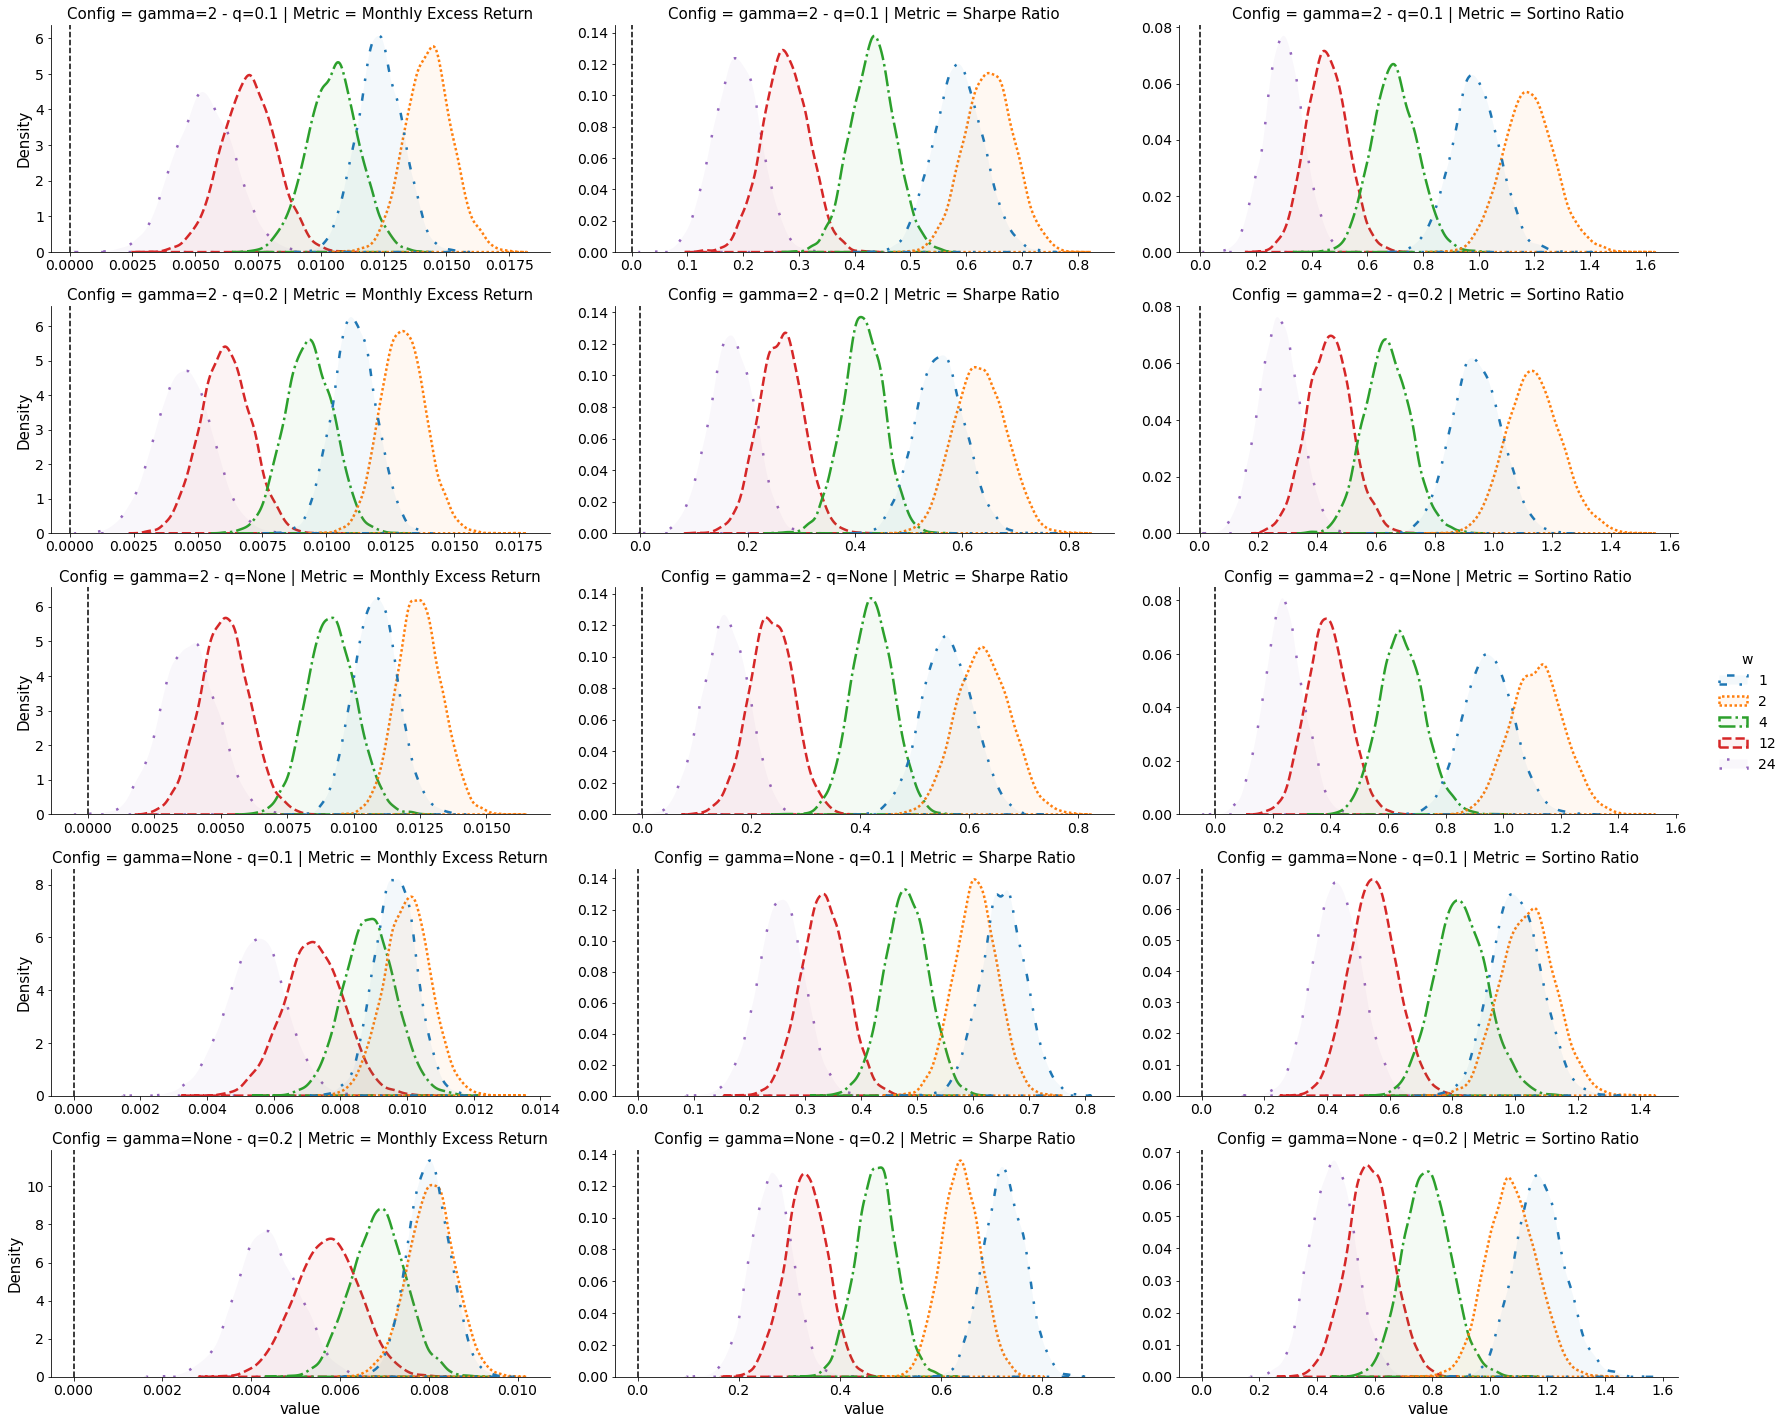

In [31]:
g = sns.displot(data=aux_trading_df, col='Metric', row='Config', palette='tab10',
                x='value', kind='kde', fill=True, alpha=.05, aspect=2, height=4,
            hue='w', linewidth=2.5, facet_kws=dict(sharex=False, sharey=False))
    
if flag_ls:
    for ax in g.axes.flat:
        for line, ls in zip(ax.collections, lss):
            line.set_linestyle(ls)
        ax.axvline(0, ls='--', color='black')

    handles = g._legend.legendHandles[::-1]
    for handle, ls in zip(handles, lss):
        handle.set_ls(ls)
else:
    for ax in g.axes.flat:
        ax.axvline(0, ls='--', color='black')

plt.savefig('img/SP500_trading.pdf')
plt.show()

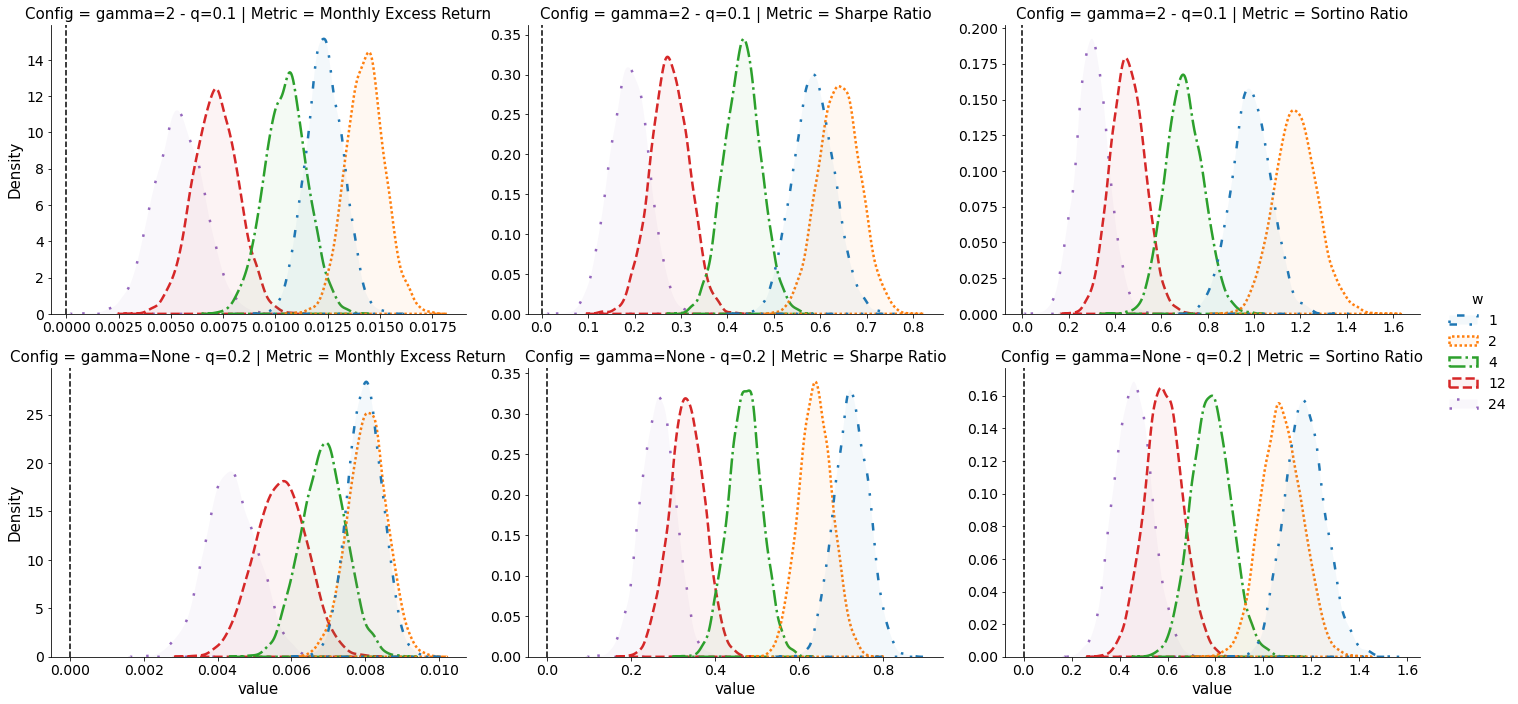

In [32]:
g = sns.displot(data=aux_trading_df[aux_trading_df['Config'].isin(trading_configs)], col='Metric', row='Config', palette='tab10',
                x='value', kind='kde', fill=True, alpha=.05, aspect=1.35, height=5,
            hue='w', linewidth=2.5, facet_kws=dict(sharex=False, sharey=False))
    
if flag_ls:
    for ax in g.axes.flat:
        for line, ls in zip(ax.collections, lss):
            line.set_linestyle(ls)
        ax.axvline(0, ls='--', color='black')

    handles = g._legend.legendHandles[::-1]
    for handle, ls in zip(handles, lss):
        handle.set_ls(ls)
else:
    for ax in g.axes.flat:
        ax.axvline(0, ls='--', color='black')

plt.savefig('img/SP500_top_trading.pdf')
plt.show()

## Performance Over Time

In [5]:
trading_configs = [
    'Quantile-std w=1 q=0.2 gamma=None both',
    'Quantile-std w=2 q=0.1 gamma=2 both',
    #'Quantile-std w=24 q=None gamma=2 both',
]

spreads_configs = [
    'Identity',
    'Corr-50',
    'LGMRF laplacian_root=True, adjust_laplacian=False',
    'SGS laplacian_root=True, adjust_laplacian=True'
]

residuals_configs = ['residuals']

In [6]:
clean_results_df = results_df.groupby(['date', 'residuals_method', 'spreads_method', 'trading_method'])['avg_month_returns'].mean().reset_index()
clean_results_df = clean_results_df[(
    clean_results_df['residuals_method'].isin(residuals_configs) &
    clean_results_df['spreads_method'].isin(spreads_configs) &
    clean_results_df['trading_method'].isin(trading_configs)
)][['date', 'residuals_method', 'spreads_method', 'trading_method', 'avg_month_returns']]
clean_results_df['trading_method'] = clean_results_df['trading_method'].str[:-4]
configuration_returns = clean_results_df.pivot(index='date', columns=['residuals_method', 'spreads_method', 'trading_method'])

In [11]:
configuration_returns_year = np.log(1 + configuration_returns.copy())
configuration_returns_year['year'] = configuration_returns.index.year
# configuration_returns_year = (np.exp(configuration_returns_year.groupby('year').mean()) - 1).reset_index()
melt_configuration_returns_year = configuration_returns_year.melt('year')
# melt_configuration_returns_year['value'] = ((1 + melt_configuration_returns_year['value']) ** 12 - 1) * 100
melt_configuration_returns_year['value'] *= 12
melt_configuration_returns_year

,year,NaN,residuals_method,spreads_method,trading_method,value
0,2000,avg_month_returns,residuals,Corr-50,Quantile-std w=1 q=0.2 gamma=None,0.963291
1,2000,avg_month_returns,residuals,Corr-50,Quantile-std w=1 q=0.2 gamma=None,-0.269356
2,2000,avg_month_returns,residuals,Corr-50,Quantile-std w=1 q=0.2 gamma=None,1.017890
3,2000,avg_month_returns,residuals,Corr-50,Quantile-std w=1 q=0.2 gamma=None,0.292423
4,2000,avg_month_returns,residuals,Corr-50,Quantile-std w=1 q=0.2 gamma=None,0.740801
...,...,...,...,...,...,...
2107,2021,avg_month_returns,residuals,"SGS laplacian_root=True, adjust_laplacian=True",Quantile-std w=2 q=0.1 gamma=2,0.132182
2108,2021,avg_month_returns,residuals,"SGS laplacian_root=True, adjust_laplacian=True",Quantile-std w=2 q=0.1 gamma=2,-0.584981
2109,2021,avg_month_returns,residuals,"SGS laplacian_root=True, adjust_laplacian=True",Quantile-std w=2 q=0.1 gamma=2,0.888852
2110,2021,avg_month_returns,residuals,"SGS laplacian_root=True, adjust_laplacian=True",Quantile-std w=2 q=0.1 gamma=2,0.284267


0       49.986422
1       94.172862
2      112.533588
3      101.056057
4       70.212207
          ...    
995     17.250952
996     25.803127
997     68.954535
998     39.132572
999     28.817937
Name: value, Length: 88000, dtype: float64

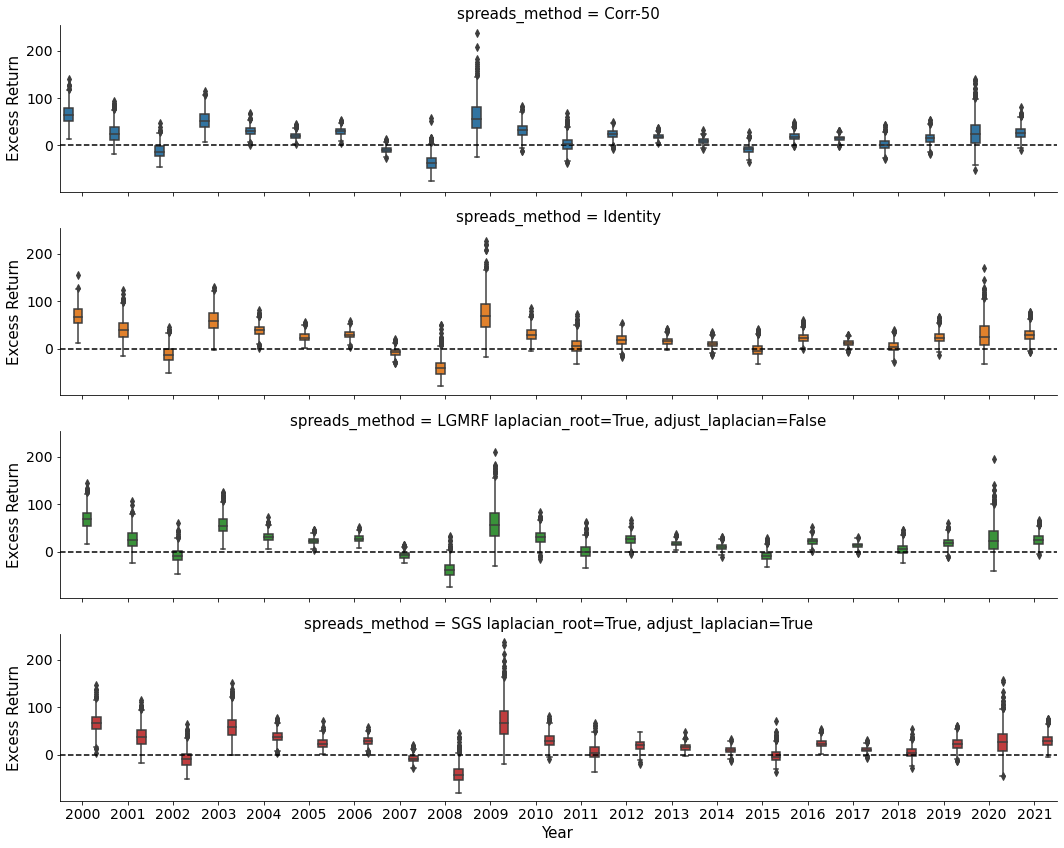

In [18]:
#configuration_returns_year
bs_expected_returns_year_spreads = bootstrap_dataset(melt_configuration_returns_year[(melt_configuration_returns_year['year'] >= 2000) & (melt_configuration_returns_year['year'] <= 2021)], 
                                                     id_vars=['year', 'spreads_method'], value_var='value', func=np.mean, n=1000)
bs_expected_returns_year_spreads['value'] = (np.exp(bs_expected_returns_year_spreads['value']) - 1) * 100
g = sns.catplot(data=bs_expected_returns_year_spreads, x='year', y='value', 
                row='spreads_method', hue='spreads_method', height=3, aspect=5, kind="box")
for ax in g.axes.flat:
    ax.axhline(0, ls='--', color='black')
    ax.set_ylabel('Excess Return')
    
plt.xlabel('Year')

plt.savefig('img/SP500_excess_return_overtime_spread.pdf')
plt.show()

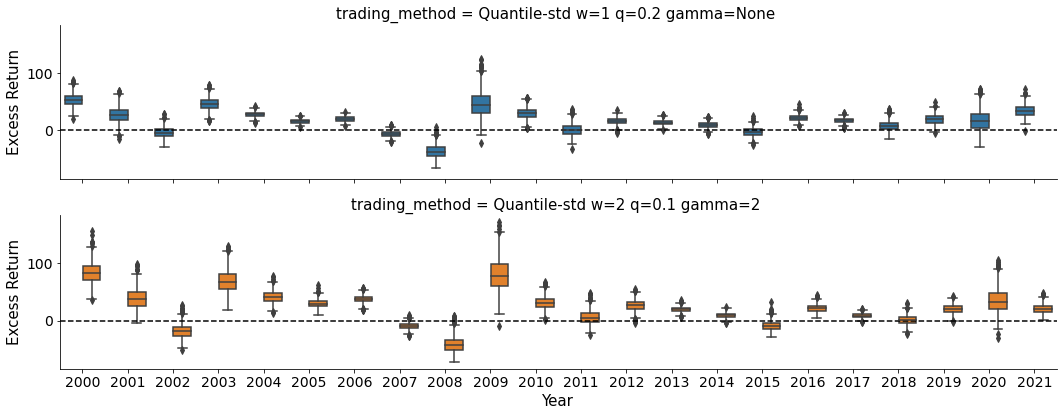

In [26]:
bs_expected_returns_year_trading = bootstrap_dataset(melt_configuration_returns_year[(melt_configuration_returns_year['year'] >= 2000) & (melt_configuration_returns_year['year'] <= 2021)], 
                                                     id_vars=['year', 'trading_method'], value_var='value', func=np.mean, n=1000)
bs_expected_returns_year_trading['value'] = (np.exp(bs_expected_returns_year_trading['value']) - 1) * 100

g = sns.catplot(data=bs_expected_returns_year_trading, x='year', y='value', 
                row='trading_method', hue='trading_method', height=3, aspect=5, kind="box")
for ax in g.axes.flat:
    ax.axhline(0, ls='--', color='black')
    ax.set_ylabel('Excess Return')
    
plt.xlabel('Year')

plt.savefig('img/SP500_excess_return_overtime_trading.pdf')
plt.show()

## 5-Factors

In [40]:
factors = pd.read_csv("data/F-F_Research_Data_5_Factors_2x3.csv", skiprows=2)
factors = factors[factors['Date'].astype(str).str.strip().str.len() == 6]
factors['Date'] = pd.to_datetime(factors['Date'].str[:-2] + '-' + factors['Date'].str[-2:] + '-01')
factors = factors.set_index('Date')
factors = factors.astype(np.float64)
factors['alpha'] = 1.
factors

,Mkt-RF,SMB,HML,RMW,CMA,RF,alpha
Date,,,,,,,
1963-07-01,-0.39,-0.41,-0.97,0.68,-1.18,0.27,1.0
1963-08-01,5.07,-0.80,1.80,0.36,-0.35,0.25,1.0
1963-09-01,-1.57,-0.52,0.13,-0.71,0.29,0.27,1.0
1963-10-01,2.53,-1.39,-0.10,2.80,-2.01,0.29,1.0
1963-11-01,-0.85,-0.88,1.75,-0.51,2.24,0.27,1.0
...,...,...,...,...,...,...,...
2022-05-01,-0.34,-0.06,8.41,1.44,3.98,0.03,1.0
2022-06-01,-8.43,1.30,-5.97,1.85,-4.70,0.06,1.0
2022-07-01,9.57,1.88,-4.10,0.68,-6.94,0.08,1.0


In [41]:
coefs = []
pvals = []
lows = []
ups = []

for col in configuration_returns.columns:
    config_ret = configuration_returns[col] * 100
    model = sm.OLS(config_ret, factors.loc[config_ret.index])
    results = model.fit()
    
    ols_results_df = pd.DataFrame(results.summary().tables[1].data).set_index(0)
    ols_results_df.columns = ols_results_df.iloc[0]
    ols_results_df = ols_results_df.iloc[1:].astype('float')
    ols_results_coef = ols_results_df['coef']
    ols_results_pval = ols_results_df['P>|t|']
    ols_results_low = ols_results_df['[0.025']
    ols_results_up = ols_results_df['0.975]']
    
    coefs.append(ols_results_coef)
    pvals.append(ols_results_pval)
    lows.append(ols_results_low)
    ups.append(ols_results_up)
    


In [42]:
coefs_df = pd.DataFrame(coefs, index=configuration_returns[('avg_month_returns', 'residuals')].columns).round(3)
pvals_df = pd.DataFrame(pvals, index=configuration_returns[('avg_month_returns', 'residuals')].columns).round(2)
lows_df = pd.DataFrame(lows, index=configuration_returns[('avg_month_returns', 'residuals')].columns).round(2)
ups_df = pd.DataFrame(ups, index=configuration_returns[('avg_month_returns', 'residuals')].columns).round(3)

In [43]:
coef_stat = ('$' + coefs_df.astype(str) + 
 np.vectorize(lambda x: '^{*}' * x)(((pvals_df > 0.01) & (pvals_df <= 0.05)).astype(int)) +
 np.vectorize(lambda x: '^{**}' * x)(((pvals_df > 0.001) & (pvals_df <= 0.01)).astype(int)) +
 np.vectorize(lambda x: '^{***}' * x)((pvals_df <= 0.001).astype(int)) +
 '$').reset_index()
# coef_stat['Configuration'] = coef_stat['spreads_method'].str.split(expand=True)[0] + ' ' + coef_stat['trading_method'].str[13:]

coef_stat['\ '] = '\\\\ & & & &'
coef_stat

,spreads_method,trading_method,Mkt-RF,SMB,HML,RMW,CMA,RF,alpha,\
0,Corr-50,Quantile-std w=1 q=0.2 gamma=None,$0.119$,$-0.123$,$-0.014$,$-0.222$,$0.357$,$0.951$,$1.098^{**}$,\\ & & & &
1,Corr-50,Quantile-std w=2 q=0.1 gamma=2,$0.126$,$-0.131$,$-0.036$,$-0.263$,$0.322$,$1.038$,$1.264^{**}$,\\ & & & &
2,Identity,Quantile-std w=1 q=0.2 gamma=None,$0.083$,$-0.084$,$-0.035$,$-0.213$,$0.287$,$0.405$,$1.23^{**}$,\\ & & & &
3,Identity,Quantile-std w=2 q=0.1 gamma=2,$0.09$,$-0.066$,$-0.043$,$-0.186$,$0.176$,$2.194$,$1.444^{**}$,\\ & & & &
4,"LGMRF laplacian_root=True, adjust_laplacian=False",Quantile-std w=1 q=0.2 gamma=None,$0.105$,$-0.141$,$0.01$,$-0.26$,$0.319$,$0.735$,$1.135^{**}$,\\ & & & &
5,"LGMRF laplacian_root=True, adjust_laplacian=False",Quantile-std w=2 q=0.1 gamma=2,$0.126$,$-0.134$,$0.017$,$-0.3$,$0.235$,$1.808$,$1.317^{**}$,\\ & & & &
6,"SGS laplacian_root=True, adjust_laplacian=True",Quantile-std w=1 q=0.2 gamma=None,$0.083$,$-0.084$,$-0.035$,$-0.213$,$0.287$,$0.405$,$1.23^{**}$,\\ & & & &
7,"SGS laplacian_root=True, adjust_laplacian=True",Quantile-std w=2 q=0.1 gamma=2,$0.088$,$-0.07$,$-0.043$,$-0.191$,$0.177$,$2.15$,$1.466^{**}$,\\ & & & &


In [44]:
configurations = coef_stat['spreads_method'].str.split(expand=True)[0] + ' ' + coef_stat['trading_method'].str[13:]
coef_stat = coef_stat.drop(columns=['spreads_method', 'trading_method'])
config_df = configurations.str.replace('w=', '').str.replace('q=', '').str.replace('gamma=', '').str.split(expand=True)
config_df.columns = ['Spread', 'w', 'q', '$\gamma$']
config_df

,Spread,w,q,$\gamma$
0,Corr-50,1,0.2,None
1,Corr-50,2,0.1,2
2,Identity,1,0.2,None
3,Identity,2,0.1,2
4,LGMRF,1,0.2,None
5,LGMRF,2,0.1,2
6,SGS,1,0.2,None
7,SGS,2,0.1,2


In [45]:
ci_df = ('(' + lows_df.astype(str) + ', ' + ups_df.astype(str) +')').reset_index(drop=True)
ci_df.columns= ['\  ', '\   ', '\    ', '\     ', '\      ', '\       ', '\        ']
ci_df

,\,\,\,\,\,\,\
0,"(-0.04, 0.277)","(-0.36, 0.111)","(-0.26, 0.233)","(-0.5, 0.059)","(-0.04, 0.75)","(-3.27, 5.175)","(0.27, 1.93)"
1,"(-0.05, 0.304)","(-0.4, 0.133)","(-0.32, 0.243)","(-0.58, 0.054)","(-0.12, 0.765)","(-3.72, 5.801)","(0.33, 2.202)"
2,"(-0.08, 0.247)","(-0.33, 0.16)","(-0.29, 0.222)","(-0.5, 0.08)","(-0.12, 0.696)","(-3.99, 4.805)","(0.36, 2.096)"
3,"(-0.11, 0.294)","(-0.37, 0.236)","(-0.36, 0.276)","(-0.55, 0.177)","(-0.33, 0.684)","(-3.26, 7.648)","(0.37, 2.517)"
4,"(-0.05, 0.263)","(-0.38, 0.093)","(-0.24, 0.258)","(-0.54, 0.021)","(-0.08, 0.712)","(-3.49, 4.963)","(0.3, 1.967)"
5,"(-0.06, 0.311)","(-0.41, 0.14)","(-0.27, 0.306)","(-0.63, 0.029)","(-0.22, 0.695)","(-3.13, 6.749)","(0.34, 2.29)"
6,"(-0.08, 0.247)","(-0.33, 0.16)","(-0.29, 0.222)","(-0.5, 0.08)","(-0.12, 0.696)","(-3.99, 4.805)","(0.36, 2.096)"
7,"(-0.12, 0.292)","(-0.37, 0.232)","(-0.36, 0.277)","(-0.55, 0.172)","(-0.33, 0.685)","(-3.31, 7.607)","(0.39, 2.54)"


In [46]:
print(pd.concat([config_df, coef_stat, ci_df], axis=1).to_latex(bold_rows=True,
                       caption='This is the caption',
                       escape=False,
                      ))

\begin{table}
\centering
\caption{This is the caption}
\begin{tabular}{llllllllllllllllllll}
\toprule
{} &    Spread &  w &    q & $\gamma$ &   Mkt-RF &       SMB &       HML &       RMW &      CMA &       RF &         alpha &          \  &             \   &            \    &           \     &          \      &         \       &        \        &      \         \\
\midrule
\textbf{0} &   Corr-50 &  1 &  0.2 &     None &  $0.119$ &  $-0.123$ &  $-0.014$ &  $-0.222$ &  $0.357$ &  $0.951$ &  $1.098^{**}$ &  \\ & & & & &  (-0.04, 0.277) &  (-0.36, 0.111) &  (-0.26, 0.233) &   (-0.5, 0.059) &   (-0.04, 0.75) &  (-3.27, 5.175) &   (0.27, 1.93) \\
\textbf{1} &   Corr-50 &  2 &  0.1 &        2 &  $0.126$ &  $-0.131$ &  $-0.036$ &  $-0.263$ &  $0.322$ &  $1.038$ &  $1.264^{**}$ &  \\ & & & & &  (-0.05, 0.304) &   (-0.4, 0.133) &  (-0.32, 0.243) &  (-0.58, 0.054) &  (-0.12, 0.765) &  (-3.72, 5.801) &  (0.33, 2.202) \\
\textbf{2} &  Identity &  1 &  0.2 &     None &  $0.083$ &  $-0.084$ &  $-0.03

In [47]:
returns = sp500_index_returns.set_index('Date').loc[configuration_returns.index]
am = arch.arch_model(returns * 100, vol="Garch", p=1, o=0, q=1, dist="Normal")
forecasts = {}
for i in range(len(returns)- 60):
    res = am.fit(first_obs=i, last_obs=i + 60, disp="off")
    temp = res.forecast(horizon=1, reindex=False).variance
    fcast = temp.iloc[0]
    forecasts[fcast.name] = fcast
    
garch_vol = pd.DataFrame(forecasts).T.reset_index().rename(columns={'h.1': 'Garch Vol.', 
                                                                    'index': 'Date'})
garch_vol

,Date,Garch Vol.
0,2005-01-01,5.728676
1,2005-02-01,6.604272
2,2005-03-01,5.964226
3,2005-04-01,6.198302
4,2005-05-01,4.577613
...,...,...
199,2021-08-01,26.192898
200,2021-09-01,26.989138
201,2021-10-01,14.974681
202,2021-11-01,14.604903


In [50]:
configuration_returns *= 100
configuration_returns

avg_month_returns  \
residuals_method                          residuals   
spreads_method                              Corr-50   
trading_method   Quantile-std w=1 q=0.2 gamma=None    
date                                                  
2000-02-01                                 8.358417   
2000-03-01                                -2.219625   
2000-04-01                                 8.852567   
2000-05-01                                 2.466795   
2000-06-01                                 6.367872   
...                                             ...   
2021-09-01                                 4.152230   
2021-10-01                                -4.071767   
2021-11-01                                 6.452423   
2021-12-01                                 0.330613   
2022-01-01                                -1.616983   

                                                  \
residuals_method                                   
spreads_method                                     
trading_method   Quantile-std w=2 q=0.1 gamma=2    
date                                               
2000-02-01                             13.686510   
2000-03-01                              3.058870   
2000-04-01                              9.422004   
2000-05-01                             -3.801664   
2000-06-01                              6.285525   
...                                          ...   
2021-09-01                             -0.601205   
2021-10-01                             -3.308023   
2021-11-01                              7.570931   
2021-12-01                              1.743113   
2022-01-01                              0.793239   

                                                     \
residuals_method                                      
spreads_method                             Identity   
trading_method   Quantile-std w=1 q=0.2 gamma=None    
date                                                  
2000-02-01                                10.277499   
2000-03-01                                -3.154355   
2000-04-01                                 6.284165   
2000-05-01                                 3.472951   
2000-06-01                                 6.372820   
...                                             ...   
2021-09-01                                 4.494620   
2021-10-01                                -5.660137   
2021-11-01                                 8.253603   
2021-12-01                                 1.656191   
2022-01-01                                -2.593848   

                                                  \
residuals_method                                   
spreads_method                                     
trading_method   Quantile-std w=2 q=0.1 gamma=2    
date                                               
2000-02-01                             15.370558   
2000-03-01                              6.217524   
2000-04-01                              7.477973   
2000-05-01                             -0.498601   
2000-06-01                              7.052294   
...                                          ...   
2021-09-01                              0.903610   
2021-10-01                             -4.757929   
2021-11-01                              7.688326   
2021-12-01                              2.397172   
2022-01-01                              1.186185   

                                                                    \
residuals_method                                                     
spreads_method   LGMRF laplacian_root=True, adjust_laplacian=False   
trading_method                  Quantile-std w=1 q=0.2 gamma=None    
date                                                                 
2000-02-01                                                7.970928   
2000-03-01                                               -1.690475   
2000-04-01                                                5.497311   
2000-05-01                                    

In [51]:
rolling_alpha_df = pd.DataFrame({col: RollingOLS(configuration_returns[col], factors.loc[configuration_returns.index], window=60).fit().params['alpha'] for col in configuration_returns.columns},
                                index=configuration_returns.index)['avg_month_returns']['residuals'].dropna()

rolling_alpha_pval_df = pd.DataFrame({col: RollingOLS(configuration_returns[col], factors.loc[configuration_returns.index], window=60).fit().pvalues[:, -1] for col in configuration_returns.columns},
             index=configuration_returns.index)['avg_month_returns']['residuals'].dropna()

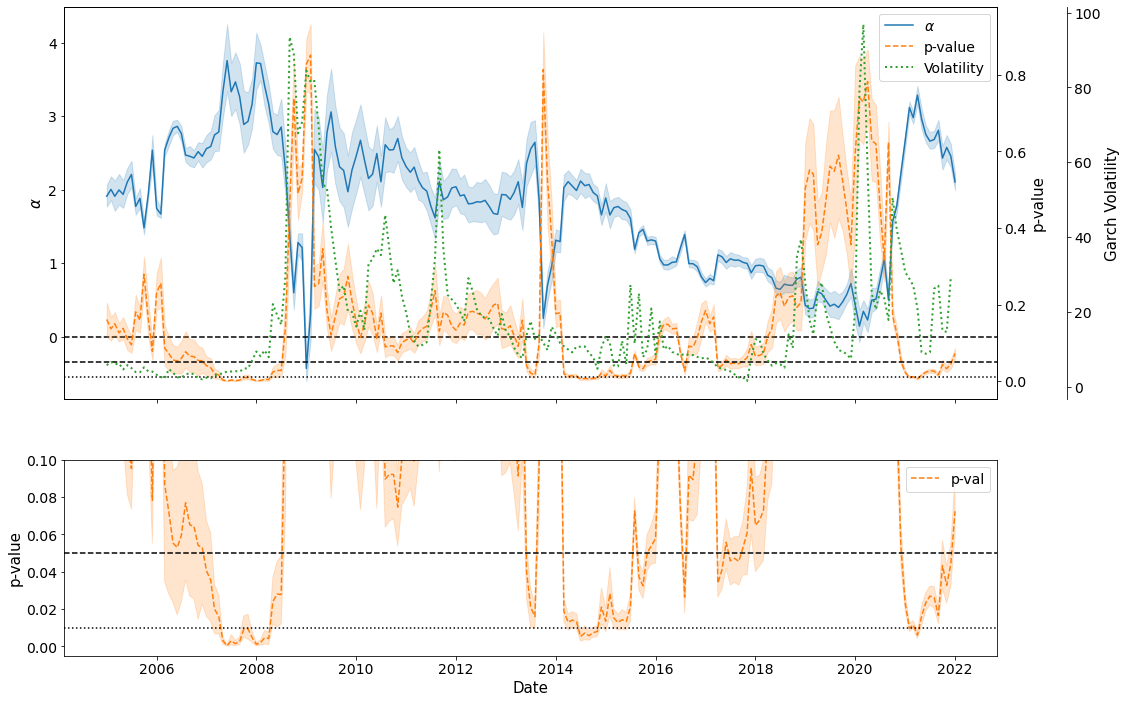

In [52]:
fig, [ax, ax_small] = plt.subplots(2, 1, figsize=(16, 10), gridspec_kw={'height_ratios': [2, 1]})

sns.lineplot(data=rolling_alpha_df.reset_index().melt('date'),
             x='date', y='value', ax=ax, label='$\\alpha$', legend=False)
ax.axhline(0, ls='--', color='black')
ax.set_ylabel('$\\alpha$')

ax2 = ax.twinx()
sns.lineplot(data=rolling_alpha_pval_df.reset_index().melt('date'),
             x='date', y='value', ax=ax2, ls='--', c='tab:orange', label='p-val', legend=False)
ax2.axhline(.05, ls='--', color='black')
ax2.axhline(.01, ls=':', color='black')
ax2.set_ylabel('p-value')

sns.lineplot(data=rolling_alpha_pval_df.reset_index().melt('date'),
             x='date', y='value', ax=ax_small, ls='--', c='tab:orange', label='p-val', legend=True)
ax_small.axhline(.05, ls='--', color='black')
ax_small.axhline(.01, ls=':', color='black')
ax_small.set_ylim(-.005, .1)
ax_small.set_ylabel('p-value')

ax3 = ax.twinx()
ax3.spines['right'].set_position(('outward', 70))

sns.lineplot(data=garch_vol, lw=2,
             x='Date', y='Garch Vol.', ax=ax3, ls=':', c='tab:green', label='vol', legend=False)
ax3.set_ylabel('Garch Volatility')

fig.tight_layout()

plt.legend([ax.get_legend_handles_labels()[0][0], 
            ax2.get_legend_handles_labels()[0][0], 
            ax3.get_legend_handles_labels()[0][0],
           ], ['$\\alpha$', 'p-value', 'Volatility'])

ax.tick_params(labelbottom=False)
ax.set_xlabel('')
ax_small.set_xlabel('Date')

plt.savefig('img/SP500_alpha_overtime.pdf')

plt.show()